# From CellBender executed output.h5 files
(Ambient RNA removal)

In [1]:
import scvi
import scanpy as sc
import pandas as pd
import h5py
import anndata
import tables
import numpy as np
import scipy.sparse as sp
from typing import Dict
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import torch
#import colorcet as cc
#from matplotlib.colors import ListedColormap
from matplotlib.pyplot import rc_context
sc.set_figure_params(dpi=100, facecolor='white')
#sc.set_figure_params(dpi=300)

/gmi-l1/_90.User_Data/hwee38/anaconda3/envs/cellrank/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /data/_90.User_Data/hwee38/anaconda3/envs/cellrank/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefINS2_6SymIntEEENS2_8optionalINS2_10ScalarTypeEEENS6_INS2_6LayoutEEENS6_INS2_6DeviceEEENS6_IbEENS6_INS2_12MemoryFormatEEE
  warn(f"Failed to load image Python extension: {e}")
Global seed set to 0
/gmi-l1/_90.User_Data/hwee38/anaconda3/envs/cellrank/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/gmi-l1/_90.User_Data/hwee38/anaconda3/envs/cellrank/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, a

In [2]:
import os
print(os.getcwd())

/data/_90.User_Data/hwee38/2.VSN_scRNA/1.analysis


In [3]:
ls

01.Cellbender_Output_Doublet_Filtering(23.03.11).ipynb
01.VSN_Solo_from_CellBender(23.04.05).ipynb
01.islet_Solo_from_CellBender(23.04.03)-Default.ipynb
VSN_cellbender_filtered_h5/


In [2]:
def anndata_from_h5(file: str,
                    analyzed_barcodes_only: bool = True) -> 'anndata.AnnData':
    """Load an output h5 file into an AnnData object for downstream work.

    Args:
        file: The h5 file
        analyzed_barcodes_only: False to load all barcodes, so that the size of
            the AnnData object will match the size of the input raw count matrix.
            True to load a limited set of barcodes: only those analyzed by the
            algorithm. This allows relevant latent variables to be loaded
            properly into adata.obs and adata.obsm, rather than adata.uns.

    Returns:
        adata: The anndata object, populated with inferred latent variables
            and metadata.

    """

    d = dict_from_h5(file)
    X = sp.csc_matrix((d.pop('data'), d.pop('indices'), d.pop('indptr')),
                      shape=d.pop('shape')).transpose().tocsr()

    # check and see if we have barcode index annotations, and if the file is filtered
    barcode_key = [k for k in d.keys() if (('barcode' in k) and ('ind' in k))]
    if len(barcode_key) > 0:
        max_barcode_ind = d[barcode_key[0]].max()
        filtered_file = (max_barcode_ind >= X.shape[0])
    else:
        filtered_file = True

    if analyzed_barcodes_only:
        if filtered_file:
            # filtered file being read, so we don't need to subset
            print('Assuming we are loading a "filtered" file that contains only cells.')
            pass
        elif 'barcode_indices_for_latents' in d.keys():
            X = X[d['barcode_indices_for_latents'], :]
            d['barcodes'] = d['barcodes'][d['barcode_indices_for_latents']]
        elif 'barcodes_analyzed_inds' in d.keys():
            X = X[d['barcodes_analyzed_inds'], :]
            d['barcodes'] = d['barcodes'][d['barcodes_analyzed_inds']]
        else:
            print('Warning: analyzed_barcodes_only=True, but the key '
                  '"barcodes_analyzed_inds" or "barcode_indices_for_latents" '
                  'is missing from the h5 file. '
                  'Will output all barcodes, and proceed as if '
                  'analyzed_barcodes_only=False')

    # Construct the anndata object.
    adata = anndata.AnnData(X=X,
                            obs={'barcode': d.pop('barcodes').astype(str)},
                            var={'gene_name': (d.pop('gene_names') if 'gene_names' in d.keys()
                                               else d.pop('name')).astype(str)},
                            dtype=X.dtype)
    adata.obs.set_index('barcode', inplace=True)
    adata.var.set_index('gene_name', inplace=True)

    # For CellRanger v2 legacy format, "gene_ids" was called "genes"... rename this
    if 'genes' in d.keys():
        d['id'] = d.pop('genes')

    # For purely aesthetic purposes, rename "id" to "gene_id"
    if 'id' in d.keys():
        d['gene_id'] = d.pop('id')

    # If genomes are empty, try to guess them based on gene_id
    if 'genome' in d.keys():
        if np.array([s.decode() == '' for s in d['genome']]).all():
            if '_' in d['gene_id'][0].decode():
                print('Genome field blank, so attempting to guess genomes based on gene_id prefixes')
                d['genome'] = np.array([s.decode().split('_')[0] for s in d['gene_id']], dtype=str)

    # Add other information to the anndata object in the appropriate slot.
    _fill_adata_slots_automatically(adata, d)

    # Add a special additional field to .var if it exists.
    if 'features_analyzed_inds' in adata.uns.keys():
        adata.var['cellbender_analyzed'] = [True if (i in adata.uns['features_analyzed_inds'])
                                            else False for i in range(adata.shape[1])]

    if analyzed_barcodes_only:
        for col in adata.obs.columns[adata.obs.columns.str.startswith('barcodes_analyzed')
                                     | adata.obs.columns.str.startswith('barcode_indices')]:
            try:
                del adata.obs[col]
            except Exception:
                pass
    else:
        # Add a special additional field to .obs if all barcodes are included.
        if 'barcodes_analyzed_inds' in adata.uns.keys():
            adata.obs['cellbender_analyzed'] = [True if (i in adata.uns['barcodes_analyzed_inds'])
                                                else False for i in range(adata.shape[0])]

    return adata


def dict_from_h5(file: str) -> Dict[str, np.ndarray]:
    """Read in everything from an h5 file and put into a dictionary."""
    d = {}
    with tables.open_file(file) as f:
        # read in everything
        for array in f.walk_nodes("/", "Array"):
            d[array.name] = array.read()
    return d


def _fill_adata_slots_automatically(adata, d):
    """Add other information to the adata object in the appropriate slot."""

    for key, value in d.items():
        try:
            if value is None:
                continue
            value = np.asarray(value)
            if len(value.shape) == 0:
                adata.uns[key] = value
            elif value.shape[0] == adata.shape[0]:
                if (len(value.shape) < 2) or (value.shape[1] < 2):
                    adata.obs[key] = value
                else:
                    adata.obsm[key] = value
            elif value.shape[0] == adata.shape[1]:
                if value.dtype.name.startswith('bytes'):
                    adata.var[key] = value.astype(str)
                else:
                    adata.var[key] = value
            else:
                adata.uns[key] = value
        except Exception:
            print('Unable to load data into AnnData: ', key, value, type(value))

In [3]:
adata = anndata_from_h5(file='/data/_90.User_Data/hwee38/2.VSN_scRNA/1.analysis/VSN_cellbender_filtered_h5/VSN6.h5')
adata.var_names_make_unique()

Assuming we are loading a "filtered" file that contains only cells.


In [4]:
adata

AnnData object with n_obs × n_vars = 8340 × 36601
    obs: 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale'
    var: 'ambient_expression', 'feature_type', 'gene_id'
    uns: 'contamination_fraction_params', 'fraction_data_used_for_testing', 'lambda_multiplier', 'overdispersion_mean_and_scale', 'target_false_positive_rate', 'test_elbo', 'test_epoch', 'training_elbo_per_epoch'
    obsm: 'latent_gene_encoding'

* highly variable genes: 1,000 - 10,000 but fewer than number cells

In [5]:
sc.pp.filter_cells(adata, min_genes = 200)
#sc.pp.filter_genes(adata, min_cells = 3)
#sc.pp.highly_variable_genes(adata, n_top_genes = 2000, subset = True, flavor = 'seurat_v3')

In [6]:
adata

AnnData object with n_obs × n_vars = 8229 × 36601
    obs: 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'n_genes'
    var: 'ambient_expression', 'feature_type', 'gene_id'
    uns: 'contamination_fraction_params', 'fraction_data_used_for_testing', 'lambda_multiplier', 'overdispersion_mean_and_scale', 'target_false_positive_rate', 'test_elbo', 'test_epoch', 'training_elbo_per_epoch'
    obsm: 'latent_gene_encoding'

In [9]:
torch.cuda.is_available()

True

In [10]:
torch.cuda.current_device()

0

In [11]:
torch.cuda.device_count()

2

In [12]:
torch.cuda.get_device_name(0)

'NVIDIA RTX A4000'

In [20]:
scvi.model.SCVI.setup_anndata(adata)
vae = scvi.model.SCVI(adata, n_hidden=128, n_layers =3, n_latent=30, gene_likelihood="zinb", dropout_rate=0.9)
vae.train(max_epochs=600, early_stopping=True, check_val_every_n_epoch=10)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 552/600:  92%|████████████████████████████▌  | 552/600 [18:13<01:35,  1.98s/it, loss=1.21e+04, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: 12251.096. Signaling Trainer to stop.


<Axes: xlabel='epoch'>

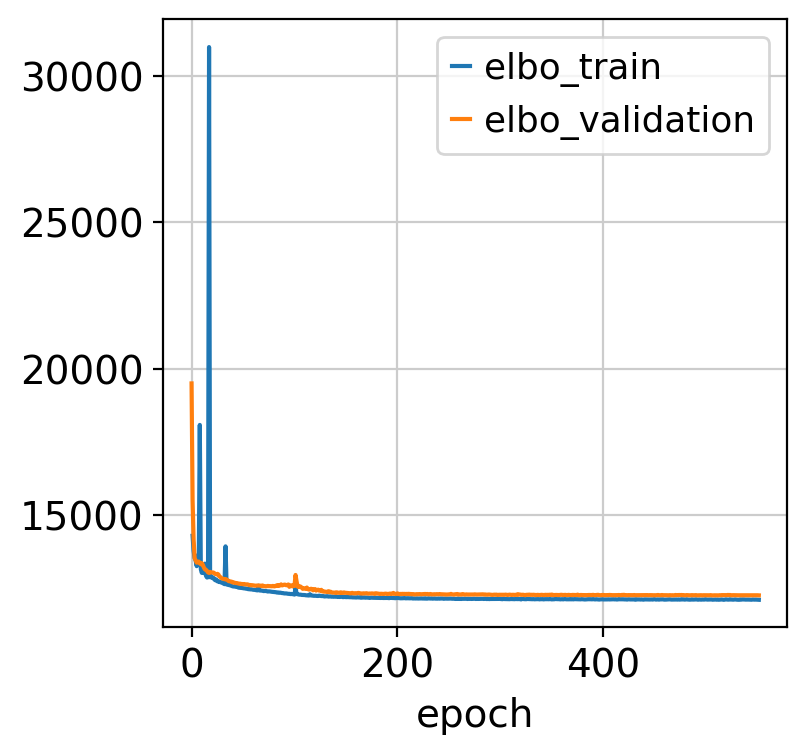

In [21]:
train_elbo = vae.history["elbo_train"][1:]
test_elbo = vae.history["elbo_validation"]
ax = train_elbo.plot()
test_elbo.plot(ax=ax)

In [13]:
scvi.model.SCVI.setup_anndata(adata)
vae = scvi.model.SCVI(adata, n_hidden=128, n_layers =3, n_latent=30, gene_likelihood="zinb", dropout_rate=0.8)
vae.train(check_val_every_n_epoch=10)

/gmi-l1/_90.User_Data/hwee38/anaconda3/envs/scvi/lib/python3.9/site-packages/scvi/model/_utils.py:287: UserWarning: This dataset has some empty cells, this might fail inference.Data should be filtered with `scanpy.pp.filter_cells()`
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 400/400: 100%|███████████████████████████████| 400/400 [06:58<00:00,  1.02s/it, loss=2.78e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|███████████████████████████████| 400/400 [06:58<00:00,  1.05s/it, loss=2.78e+03, v_num=1]


<AxesSubplot: xlabel='epoch'>

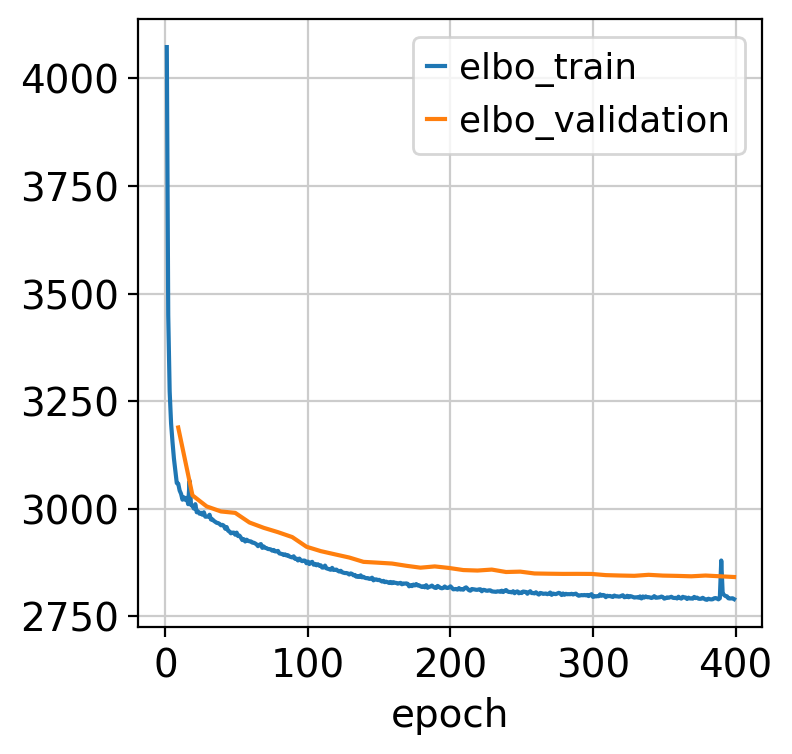

In [14]:
train_elbo = vae.history["elbo_train"][1:]
test_elbo = vae.history["elbo_validation"]
ax = train_elbo.plot()
test_elbo.plot(ax=ax)

In [7]:
scvi.model.SCVI.setup_anndata(adata)
vae = scvi.model.SCVI(adata, dropout_rate=0.8)
vae.train(max_epochs=400, early_stopping=True, check_val_every_n_epoch=10)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 400/400: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [09:26<00:00,  1.53s/it, loss=1.15e+04, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [09:26<00:00,  1.42s/it, loss=1.15e+04, v_num=1]


<Axes: xlabel='epoch'>

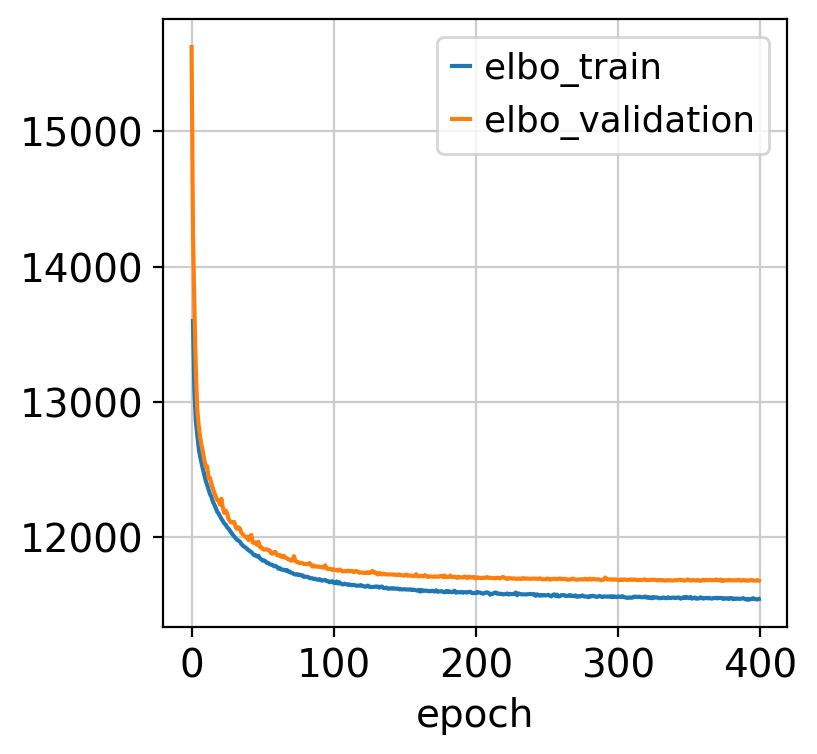

In [8]:
train_elbo = vae.history["elbo_train"][1:]
test_elbo = vae.history["elbo_validation"]
ax = train_elbo.plot()
test_elbo.plot(ax=ax)

In [29]:
vae.history

{'kl_weight':       kl_weight
 epoch          
 0           0.0
 1        0.0025
 2         0.005
 3        0.0075
 4          0.01
 ...         ...
 395      0.9875
 396        0.99
 397      0.9925
 398       0.995
 399      0.9975
 
 [400 rows x 1 columns],
 'train_loss_step':       train_loss_step
 epoch                
 0          736.818115
 1          530.202209
 2          485.992126
 3          458.660461
 4          429.271637
 ...               ...
 395        360.414886
 396         339.22229
 397        376.622559
 398        374.781799
 399        375.571869
 
 [400 rows x 1 columns],
 'train_loss_epoch':       train_loss_epoch
 epoch                 
 0          1068.745239
 1           622.327087
 2           505.520142
 3           466.534637
 4           446.595215
 ...                ...
 395         368.276886
 396          369.36142
 397         368.610779
 398         368.225037
 399         368.606354
 
 [400 rows x 1 columns],
 'elbo_train':         elbo_train
 

In [7]:
solo = scvi.external.SOLO.from_scvi_model(vae)
solo.train()

/gmi-l1/_90.User_Data/hwee38/anaconda3/envs/cellrank/lib/python3.9/site-packages/scvi/external/solo/_model.py:243: FutureWarning: X.dtype being converted to np.float32 from uint32. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  doublets_ad = AnnData(doublets)


INFO     Creating doublets, preparing SOLO model.                                                                  


/gmi-l1/_90.User_Data/hwee38/anaconda3/envs/cellrank/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/gmi-l1/_90.User_Data/hwee38/anaconda3/envs/cellrank/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: Fal

Epoch 145/400:  36%|████████████████████████████████████████▌                                                                       | 145/400 [01:12<02:08,  1.99it/s, loss=0.328, v_num=1]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.315. Signaling Trainer to stop.


In [8]:
df = solo.predict()
df['prediction'] = solo.predict(soft = False)
df.index = df.index.map(lambda x: x[:-2])

df

,doublet,singlet,prediction
TGCTCGTAGGAGTCTG-1,0.137377,1.773614,singlet
TCTACATAGTGGCAGT-1,2.539603,-1.460865,doublet
TATTGGGCACTCCCTA-1,0.778964,-0.137235,doublet
CGGAGAATCCCGAGGT-1,1.519229,-0.249868,doublet
GATCCCTAGCTCATAC-1,2.226817,-1.830316,doublet
...,...,...,...
CCACGAGGTCAAGTTC-1,-5.446592,4.494348,singlet
GACCCAGAGCAATTCC-1,-6.422710,5.377535,singlet
TGAGCGCGTCGAGTGA-1,-4.037592,2.954316,singlet
CGAAGGAGTCCTGTCT-1,-5.310564,4.602039,singlet


In [9]:
len(df[df.prediction == 'doublet']) 

1353

In [10]:
len(df[df.prediction == 'singlet']) 

6876

In [11]:
df['dif'] = df.doublet - df.singlet
df

,doublet,singlet,prediction,dif
TGCTCGTAGGAGTCTG-1,0.137377,1.773614,singlet,-1.636237
TCTACATAGTGGCAGT-1,2.539603,-1.460865,doublet,4.000468
TATTGGGCACTCCCTA-1,0.778964,-0.137235,doublet,0.916199
CGGAGAATCCCGAGGT-1,1.519229,-0.249868,doublet,1.769098
GATCCCTAGCTCATAC-1,2.226817,-1.830316,doublet,4.057133
...,...,...,...,...
CCACGAGGTCAAGTTC-1,-5.446592,4.494348,singlet,-9.940940
GACCCAGAGCAATTCC-1,-6.422710,5.377535,singlet,-11.800245
TGAGCGCGTCGAGTGA-1,-4.037592,2.954316,singlet,-6.991908
CGAAGGAGTCCTGTCT-1,-5.310564,4.602039,singlet,-9.912603


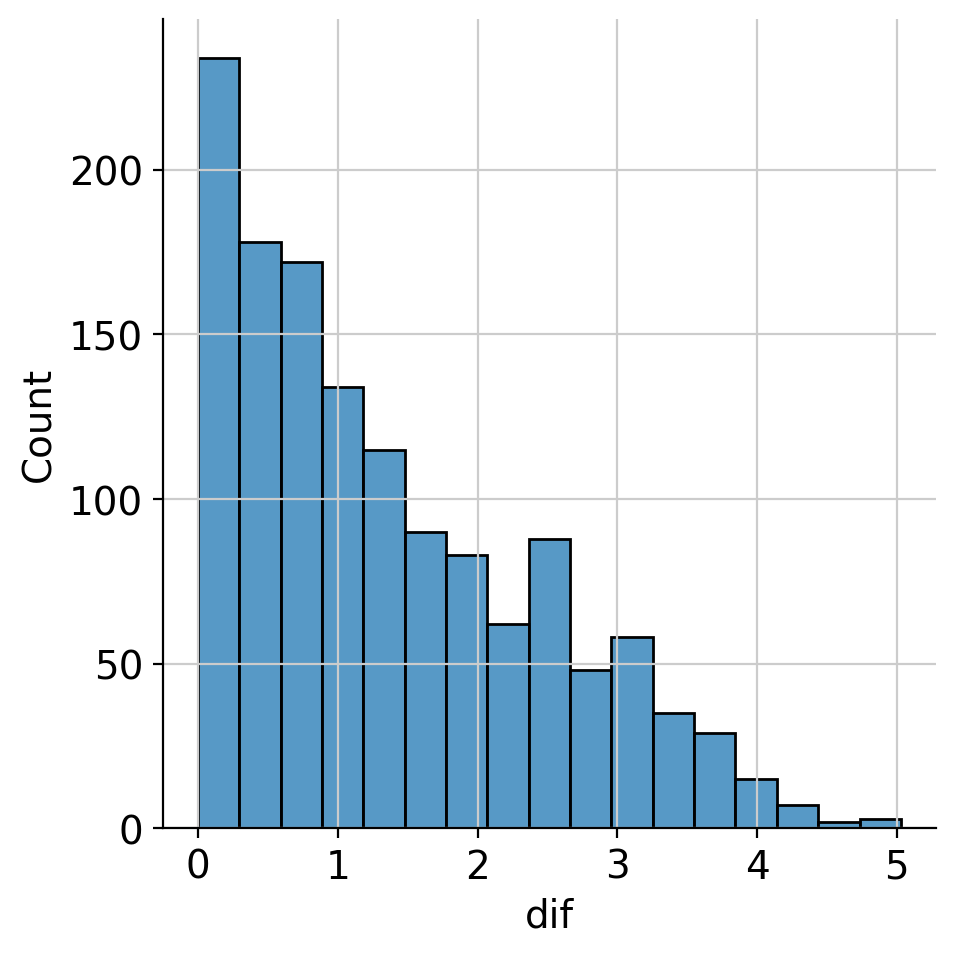

In [12]:
sns.displot(df[df.prediction == 'doublet'], x = 'dif')

In [18]:
doublets = df[(df.prediction == 'doublet') & (df.dif > 1.3)]
doublets

,doublet,singlet,prediction,dif
TCTACATAGTGGCAGT-1,2.539603,-1.460865,doublet,4.000468
CGGAGAATCCCGAGGT-1,1.519229,-0.249868,doublet,1.769098
GATCCCTAGCTCATAC-1,2.226817,-1.830316,doublet,4.057133
CTAACTTTCTCATGGA-1,1.514921,-1.062979,doublet,2.577900
AGGGTTTAGTCCCAAT-1,1.594224,-0.553602,doublet,2.147826
...,...,...,...,...
CCGGACAGTGACTCGC-1,0.652421,-0.670208,doublet,1.322629
TGGGCTGAGGAAGTCC-1,0.744633,-0.695648,doublet,1.440280
GAATCACTCTTGGCTC-1,0.620771,-1.106040,doublet,1.726811
CCTCCTCAGCCATCCG-1,1.223437,-1.361845,doublet,2.585283


In [18]:
len(df[df.prediction == 'doublet']) 

2218

In [17]:
len(df[df.prediction == 'singlet']) 

6011

/gmi-l1/_90.User_Data/hwee38/anaconda3/envs/cellrank/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/gmi-l1/_90.User_Data/hwee38/anaconda3/envs/cellrank/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


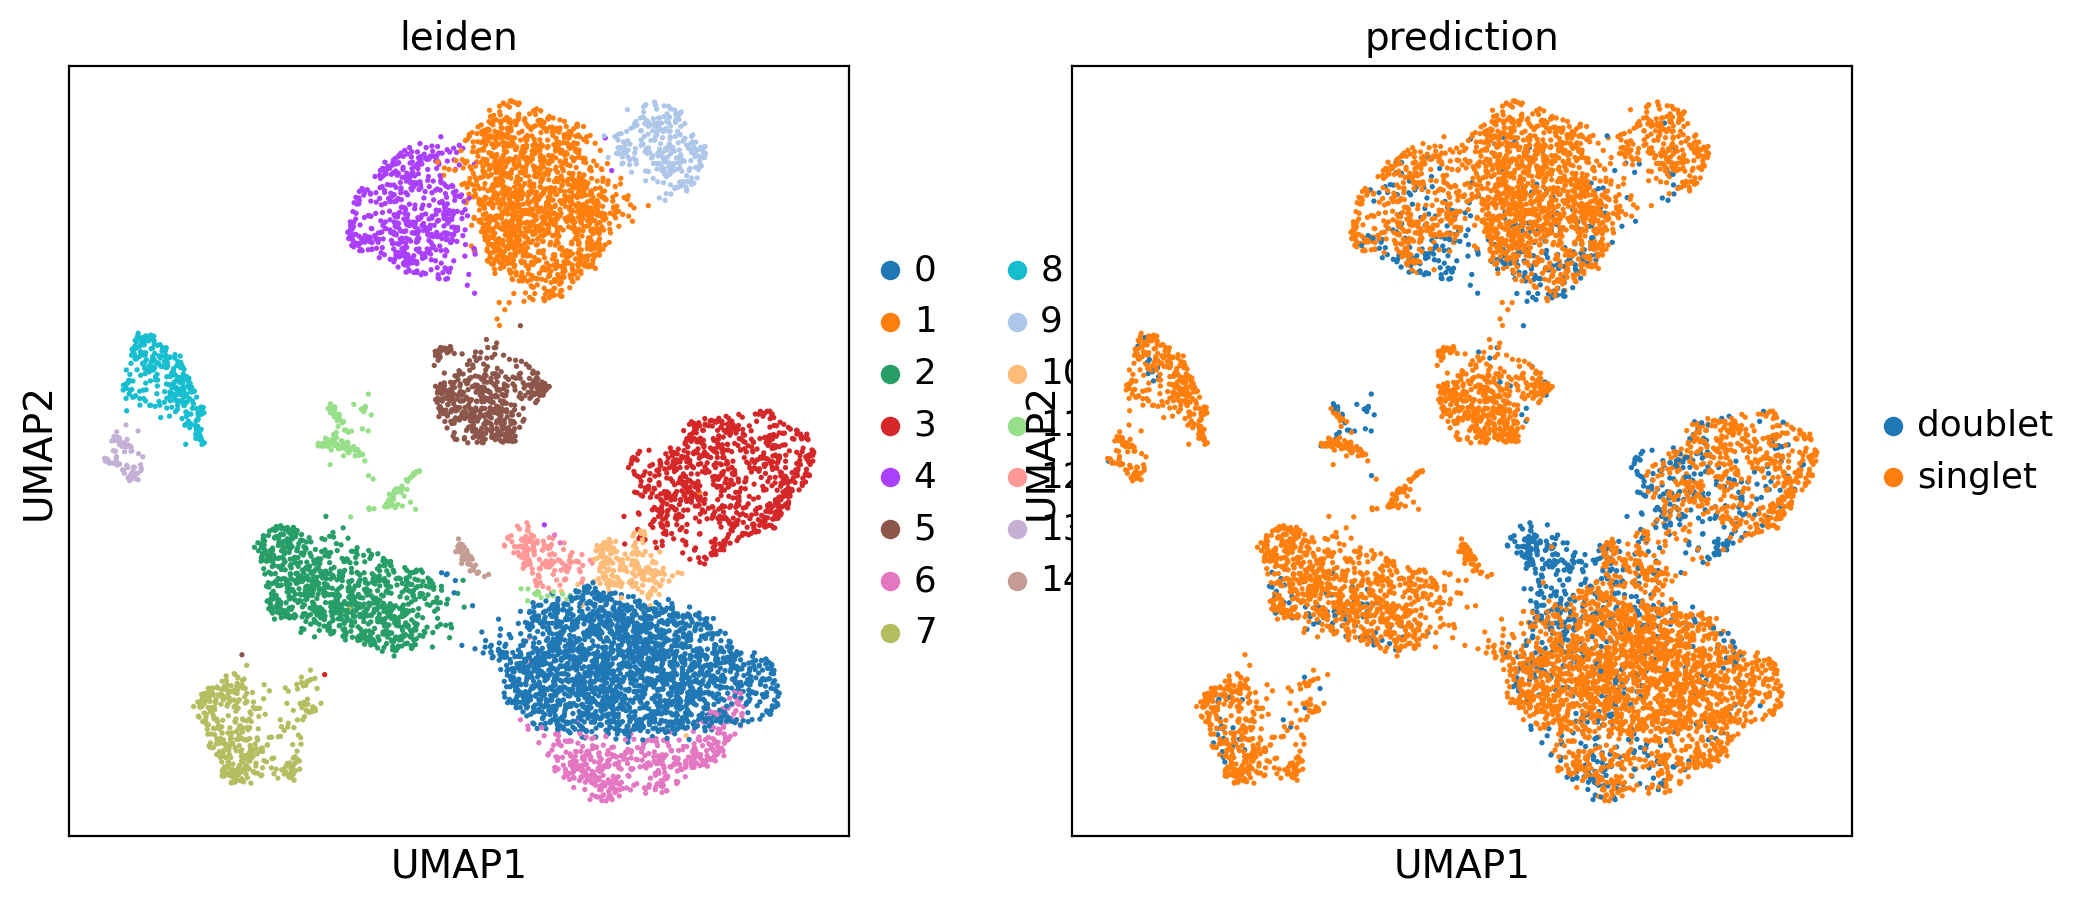

In [19]:
#THIS STEP IS NOT NECESSARY, just to visuallize results 
adata.obs['prediction'] = df.prediction
sc.pp.normalize_total(adata, target_sum = 1e4)
sc.pp.log1p(adata)
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution = 0.5)

with rc_context({'figure.figsize': (5, 5)}):
    sc.pl.umap(adata, color = ['leiden', 'prediction'])

In [20]:
adata.obs

,latent_RT_efficiency,latent_cell_probability,latent_scale,n_genes,_scvi_batch,_scvi_labels,prediction,leiden
barcode,,,,,,,,
TGCTCGTAGGAGTCTG-1,4.052102,0.999963,21537.306641,9037,0,0,singlet,0
TCTACATAGTGGCAGT-1,3.541094,0.999969,26189.875000,11732,0,0,doublet,11
TATTGGGCACTCCCTA-1,3.456252,0.999975,30438.990234,10300,0,0,doublet,11
CGGAGAATCCCGAGGT-1,3.365476,0.999987,21255.189453,8778,0,0,doublet,6
GATCCCTAGCTCATAC-1,3.140113,0.999989,23699.693359,9799,0,0,doublet,6
...,...,...,...,...,...,...,...,...
CCACGAGGTCAAGTTC-1,0.239814,0.998502,10848.088867,709,0,0,singlet,2
GACCCAGAGCAATTCC-1,0.435944,0.998513,12661.661133,575,0,0,singlet,2
TGAGCGCGTCGAGTGA-1,0.178374,0.998285,10690.360352,817,0,0,singlet,7


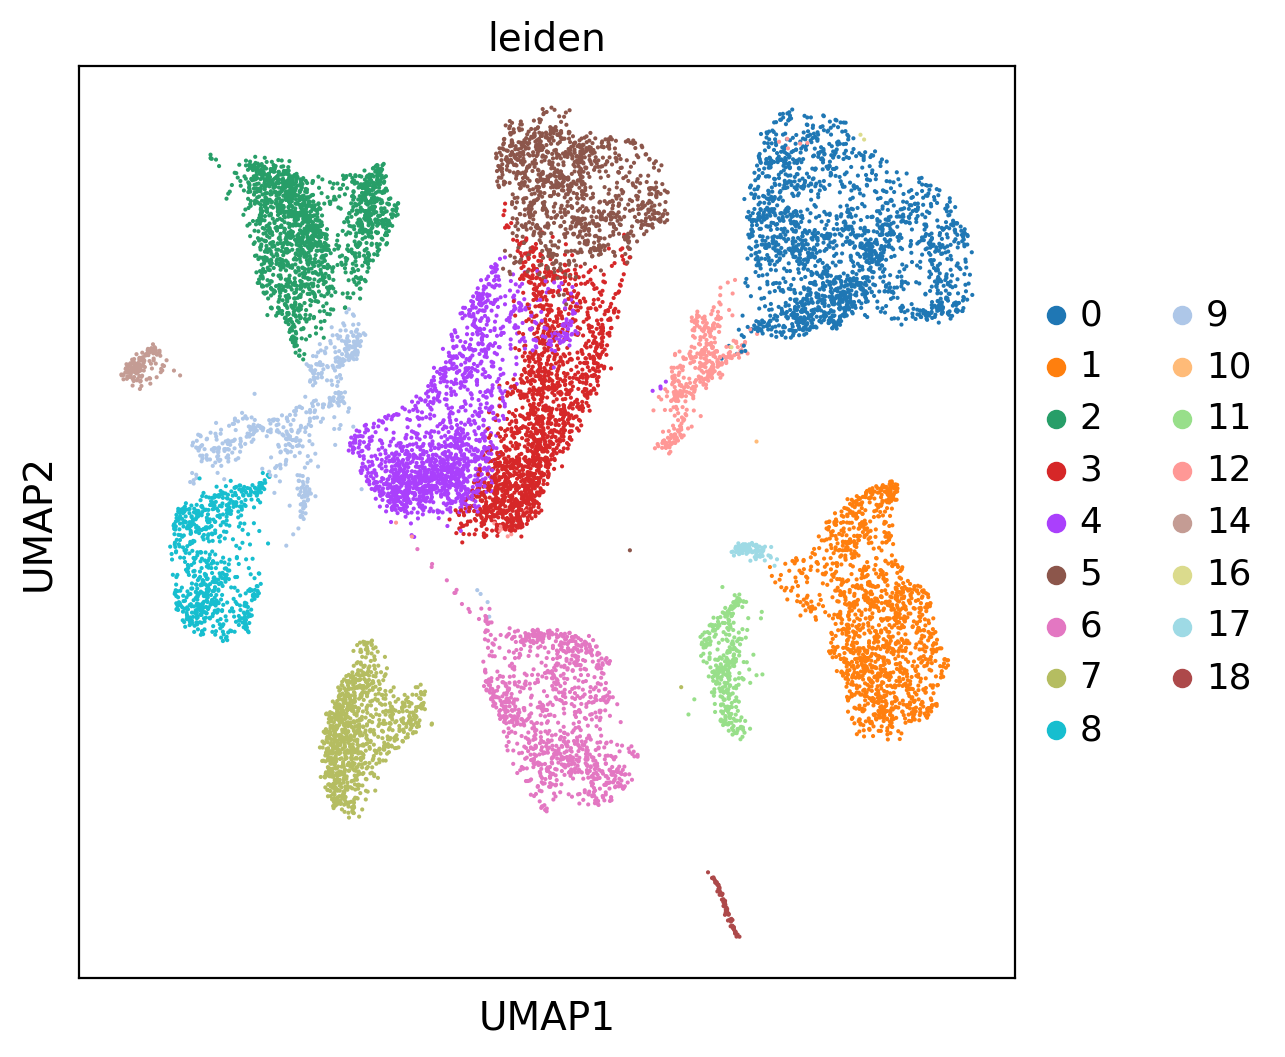

In [37]:
with rc_context({'figure.figsize': (6, 6)}):
    sc.pl.umap(adata, color = ['leiden'], save="EMPD_filtered.pdf")

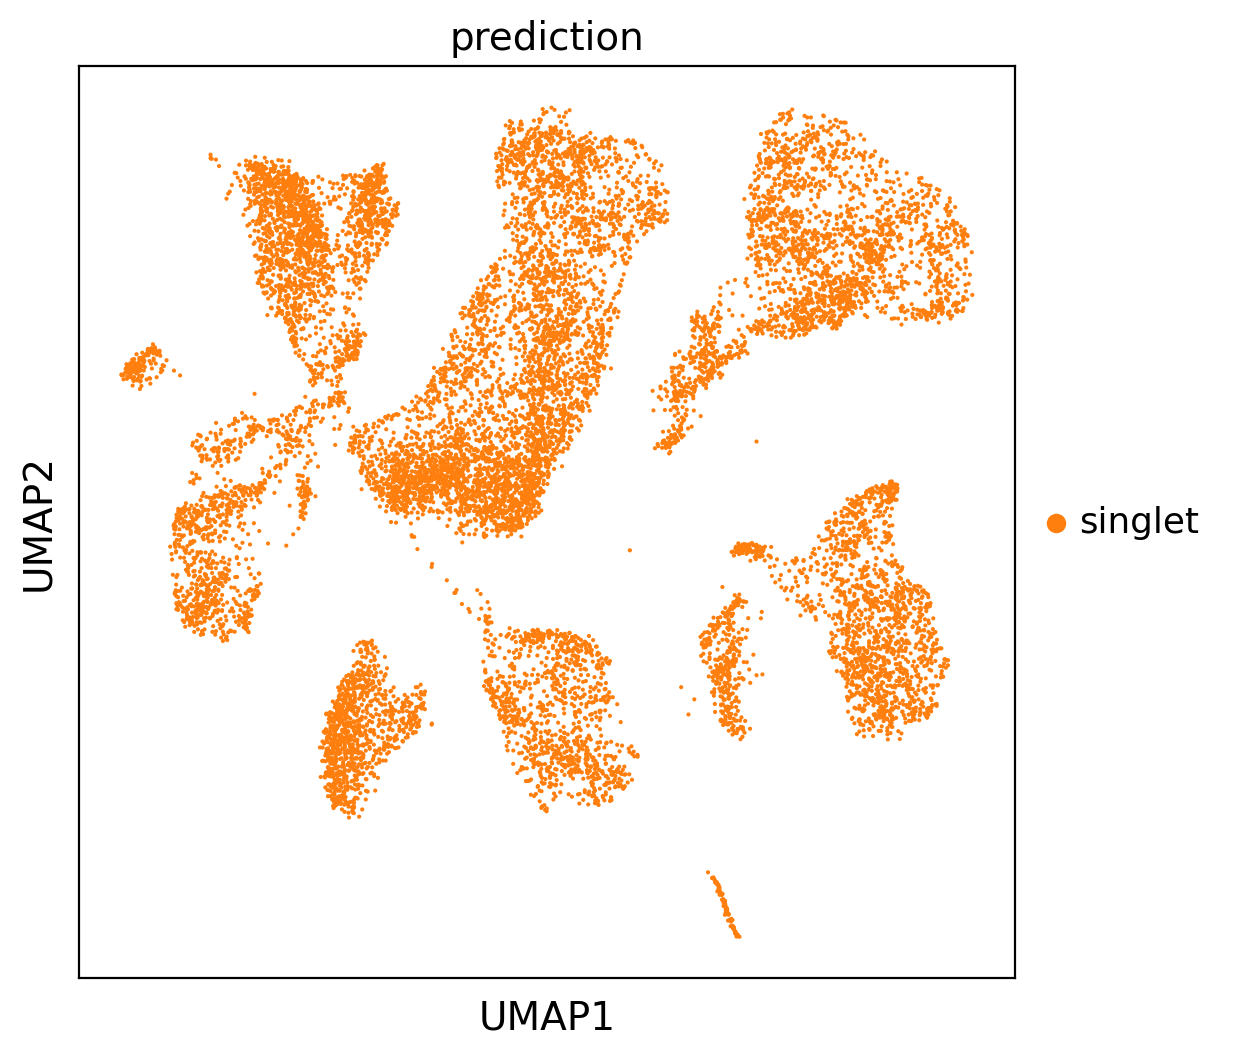

In [36]:
with rc_context({'figure.figsize': (6, 6)}):
    sc.pl.umap(adata, color = ['prediction'], save="EMPD_doublet_prediction_filtered.pdf")

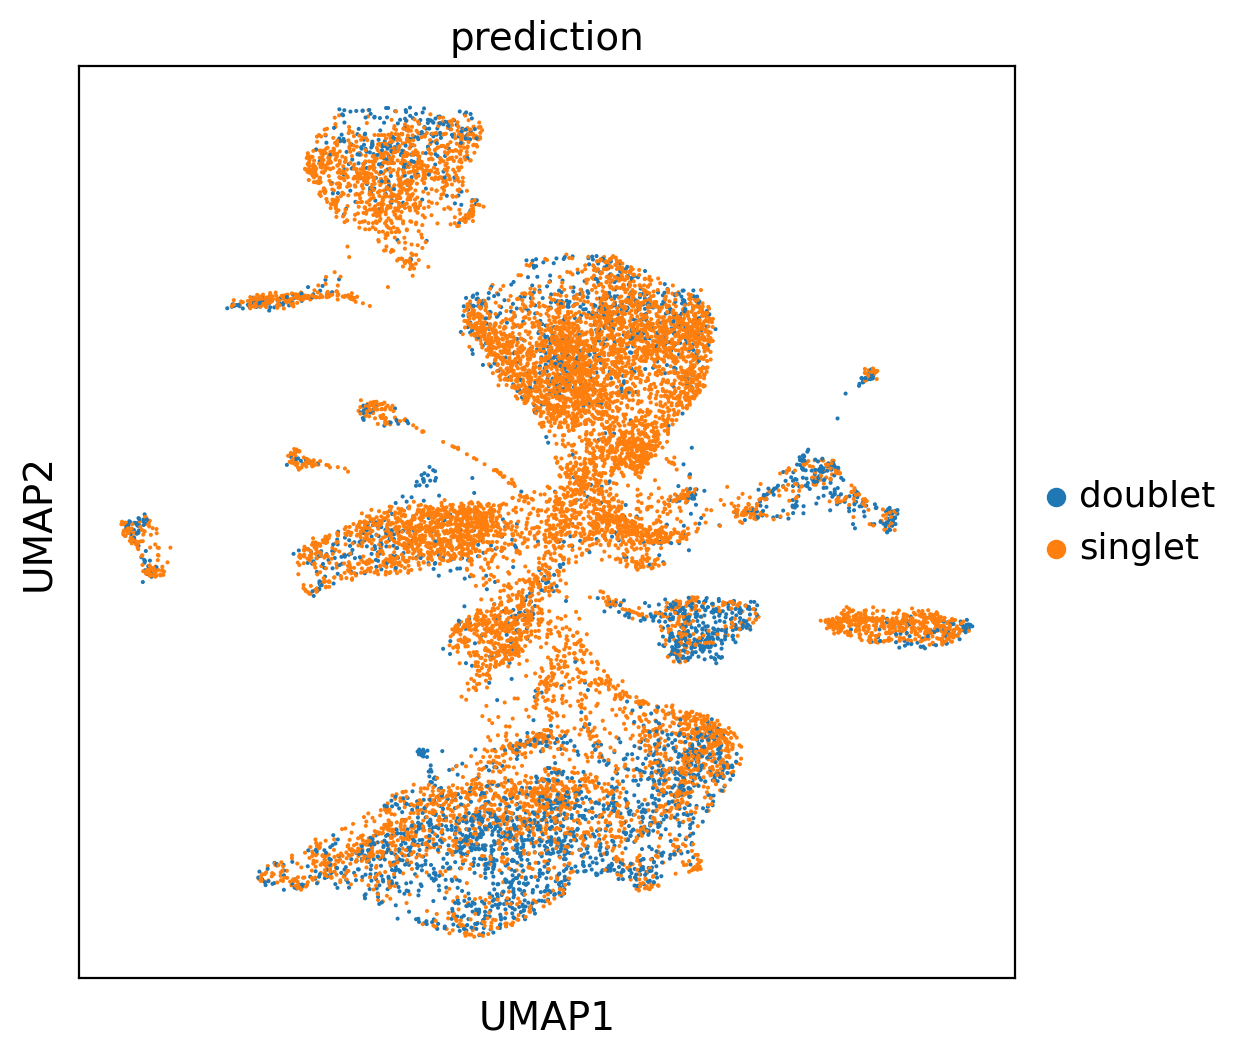

In [13]:
with rc_context({'figure.figsize': (6, 6)}):
    sc.pl.umap(adata, color = ['prediction'])

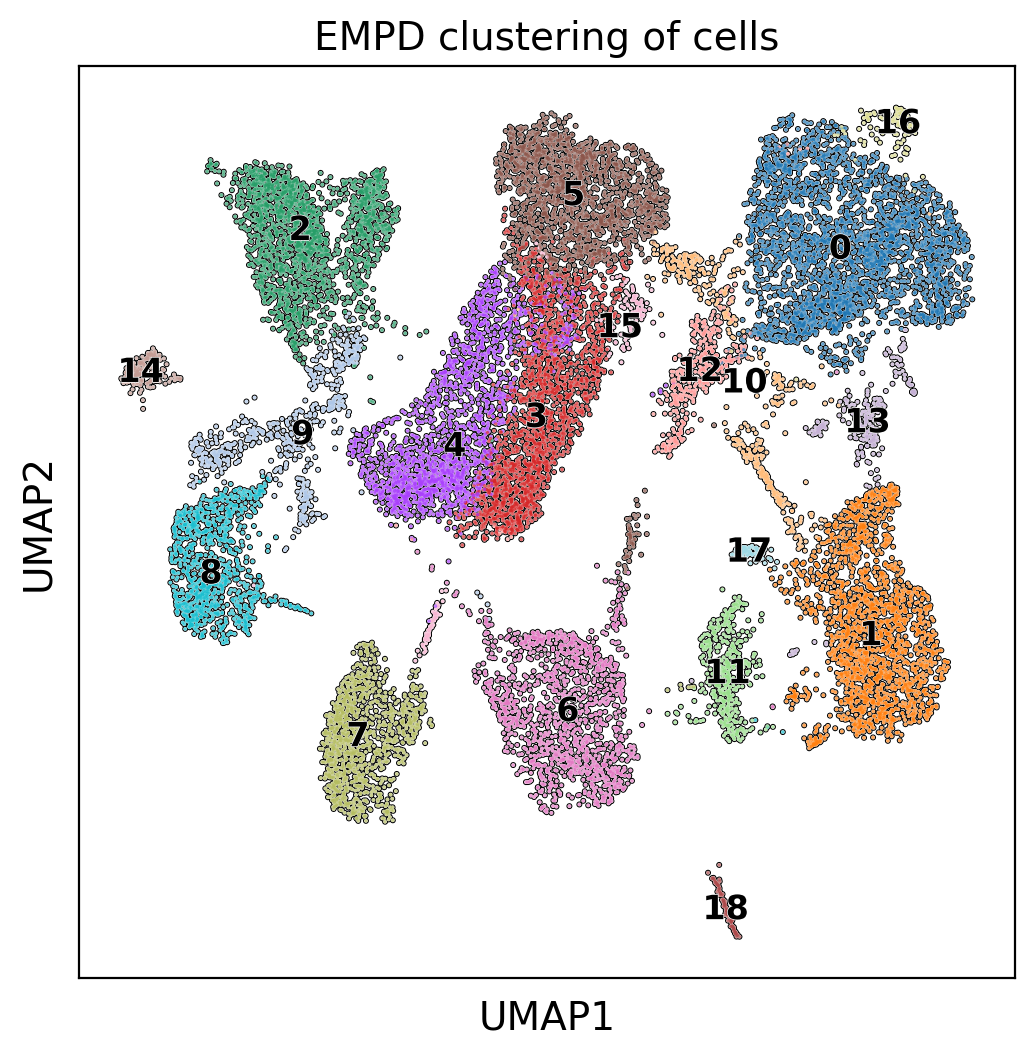

In [22]:
with rc_context({'figure.figsize': (6, 6)}):
    sc.pl.umap(adata, color = ['leiden'], add_outline=True, legend_loc='on data',
               legend_fontsize=12, legend_fontoutline=0.5,frameon=True,
               title='EMPD clustering of cells', save="EMPD_clustering_of_cells.pdf")

In [14]:
adata 

AnnData object with n_obs × n_vars = 13946 × 5000
    obs: 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'n_genes', '_scvi_batch', '_scvi_labels', 'prediction', 'leiden'
    var: 'ambient_expression', 'feature_type', 'gene_id', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'contamination_fraction_params', 'fraction_data_used_for_testing', 'lambda_multiplier', 'overdispersion_mean_and_scale', 'target_false_positive_rate', 'test_elbo', 'test_epoch', 'training_elbo_per_epoch', 'hvg', '_scvi_uuid', '_scvi_manager_uuid', 'log1p', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'prediction_colors'
    obsm: 'latent_gene_encoding', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [21]:
doublet_d = dict(zip(df.index, df.prediction))
doublet_d

{'TGCTCGTAGGAGTCTG-1': 'singlet',
 'TCTACATAGTGGCAGT-1': 'doublet',
 'TATTGGGCACTCCCTA-1': 'doublet',
 'CGGAGAATCCCGAGGT-1': 'doublet',
 'GATCCCTAGCTCATAC-1': 'doublet',
 'CTAACTTTCTCATGGA-1': 'doublet',
 'AGGGTTTAGTCCCAAT-1': 'doublet',
 'TCATTGTAGTCACGAG-1': 'doublet',
 'CTTCTCTCATTGTACG-1': 'doublet',
 'CCTCAACTCCACACAA-1': 'doublet',
 'ATTCTACGTGGGTTGA-1': 'doublet',
 'TGTTCCGAGTCTCCTC-1': 'doublet',
 'CTGTATTAGCCTCTCT-1': 'doublet',
 'ACAGGGACACTGCGTG-1': 'doublet',
 'ATGCATGTCCATTCAT-1': 'doublet',
 'AAGCCATAGAGCAACC-1': 'doublet',
 'TTCTCTCTCTGGACCG-1': 'singlet',
 'TTCGCTGTCCTCGCAT-1': 'doublet',
 'CCTATCGCACACCTGG-1': 'doublet',
 'AGCCAATCAGTCGCAC-1': 'doublet',
 'ACTATGGAGGATACAT-1': 'doublet',
 'CCCGGAATCTCCTGCA-1': 'doublet',
 'TTCATTGTCGCACTCT-1': 'doublet',
 'CTAACCCAGACCATGG-1': 'doublet',
 'GAGCTGCTCTACCCAC-1': 'doublet',
 'CATTGAGCAGCCATTA-1': 'doublet',
 'GTAGATCCAACGATTC-1': 'doublet',
 'GTAACACTCTCTATGT-1': 'doublet',
 'TCCTCCCAGTGAGTGC-1': 'doublet',
 'CATCAAGGTAGA

In [22]:
doublet_d = dict(zip(df.index, df.prediction))

def im_a_function(x):
    try:
        return doublet_d[x]
    except:
        return 'filtered'

In [29]:
adata = anndata_from_h5(file='/data/_90.User_Data/hwee38/2.VSN_scRNA/1.analysis/VSN_cellbender_filtered_h5/VSN6.h5')
adata.var_names_make_unique()

Assuming we are loading a "filtered" file that contains only cells.


In [31]:
adata.obs['doublet'] = adata.obs.index.isin(doublets.index)
adata = adata[~adata.obs.doublet]

In [32]:
adata

View of AnnData object with n_obs × n_vars = 7752 × 36601
    obs: 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'doublet'
    var: 'ambient_expression', 'feature_type', 'gene_id'
    uns: 'contamination_fraction_params', 'fraction_data_used_for_testing', 'lambda_multiplier', 'overdispersion_mean_and_scale', 'target_false_positive_rate', 'test_elbo', 'test_epoch', 'training_elbo_per_epoch'
    obsm: 'latent_gene_encoding'

In [33]:
adata.obs

,latent_RT_efficiency,latent_cell_probability,latent_scale,doublet
barcode,,,,
TGCTCGTAGGAGTCTG-1,4.052102,0.999963,21537.306641,False
TATTGGGCACTCCCTA-1,3.456252,0.999975,30438.990234,False
ATTCTACGTGGGTTGA-1,3.269656,0.999975,25193.042969,False
AAGCCATAGAGCAACC-1,2.862629,0.999985,21303.671875,False
TTCTCTCTCTGGACCG-1,3.359915,0.999952,22659.720703,False
...,...,...,...,...
TCACTCGGTGCAGGAT-1,0.545919,0.989732,11489.345703,False
TACCGGGGTCGTCTCT-1,0.555557,0.982297,11812.528320,False
TTGCCTGGTCTCGACG-1,0.549061,0.985410,11753.623047,False


In [34]:
adata.write_h5ad("VSN6_solo.h5ad")

/gmi-l1/_90.User_Data/hwee38/anaconda3/envs/cellrank/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c
/gmi-l1/_90.User_Data/hwee38/anaconda3/envs/cellrank/lib/python3.9/contextlib.py:126: FutureWarning: X.dtype being converted to np.float32 from uint32. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)


In [ ]:
adata = sc.read_10x_h5('EMPD_filtered_feature_bc_matrix.h5')
adata.var_names_make_unique()

In [38]:
#adata = anndata_from_h5(file='MODIFIED_EMPD_OUTPUT.h5')
#adata.var_names_make_unique()

Assuming we are loading a "filtered" file that contains only cells.


In [23]:
adata.obs['doublet'] = adata.obs.index.map(im_a_function)

In [24]:
adata

AnnData object with n_obs × n_vars = 8229 × 36601
    obs: 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'n_genes', '_scvi_batch', '_scvi_labels', 'prediction', 'leiden', 'doublet'
    var: 'ambient_expression', 'feature_type', 'gene_id'
    uns: 'contamination_fraction_params', 'fraction_data_used_for_testing', 'lambda_multiplier', 'overdispersion_mean_and_scale', 'target_false_positive_rate', 'test_elbo', 'test_epoch', 'training_elbo_per_epoch', '_scvi_uuid', '_scvi_manager_uuid', 'log1p', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'prediction_colors'
    obsm: 'latent_gene_encoding', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [25]:
adata.obs

,latent_RT_efficiency,latent_cell_probability,latent_scale,n_genes,_scvi_batch,_scvi_labels,prediction,leiden,doublet
barcode,,,,,,,,,
TGCTCGTAGGAGTCTG-1,4.052102,0.999963,21537.306641,9037,0,0,singlet,0,singlet
TCTACATAGTGGCAGT-1,3.541094,0.999969,26189.875000,11732,0,0,doublet,11,doublet
TATTGGGCACTCCCTA-1,3.456252,0.999975,30438.990234,10300,0,0,doublet,11,doublet
CGGAGAATCCCGAGGT-1,3.365476,0.999987,21255.189453,8778,0,0,doublet,6,doublet
GATCCCTAGCTCATAC-1,3.140113,0.999989,23699.693359,9799,0,0,doublet,6,doublet
...,...,...,...,...,...,...,...,...,...
CCACGAGGTCAAGTTC-1,0.239814,0.998502,10848.088867,709,0,0,singlet,2,singlet
GACCCAGAGCAATTCC-1,0.435944,0.998513,12661.661133,575,0,0,singlet,2,singlet
TGAGCGCGTCGAGTGA-1,0.178374,0.998285,10690.360352,817,0,0,singlet,7,singlet


In [26]:
len(adata[adata.obs.doublet == 'doublet'])

1353

In [27]:
len(adata[adata.obs.doublet == 'singlet'])

6876

In [28]:
len(adata[adata.obs.doublet == 'filtered'])

0

In [24]:
adata

AnnData object with n_obs × n_vars = 18927 × 36601
    obs: 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'doublet'
    var: 'ambient_expression', 'feature_type', 'gene_id'
    uns: 'contamination_fraction_params', 'fraction_data_used_for_testing', 'lambda_multiplier', 'overdispersion_mean_and_scale', 'target_false_positive_rate', 'test_elbo', 'test_epoch', 'training_elbo_per_epoch'
    obsm: 'latent_gene_encoding'

In [39]:
adata

View of AnnData object with n_obs × n_vars = 11377 × 36601
    obs: 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'doublet'
    var: 'ambient_expression', 'feature_type', 'gene_id'
    uns: 'contamination_fraction_params', 'fraction_data_used_for_testing', 'lambda_multiplier', 'overdispersion_mean_and_scale', 'target_false_positive_rate', 'test_elbo', 'test_epoch', 'training_elbo_per_epoch'
    obsm: 'latent_gene_encoding'

In [35]:
adata.write("CTRL2_before_doubletfiltered_cellbender.h5")

In [25]:
adata = adata[adata.obs.doublet == 'singlet']

In [27]:
adata

View of AnnData object with n_obs × n_vars = 10338 × 36601
    obs: 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'doublet'
    var: 'ambient_expression', 'feature_type', 'gene_id'
    uns: 'contamination_fraction_params', 'fraction_data_used_for_testing', 'lambda_multiplier', 'overdispersion_mean_and_scale', 'target_false_positive_rate', 'test_elbo', 'test_epoch', 'training_elbo_per_epoch'
    obsm: 'latent_gene_encoding'

In [29]:
adata.write("public_EMPD2_singlet.h5ad")

# 2nd sample doublet filtering (repeat)

In [ ]:
scvi.model.SCVI.setup_anndata(adata2)
vae2 = scvi.model.SCVI(adata2)
vae2.train()

In [ ]:
solo2 = scvi.external.SOLO.from_scvi_model(vae2)
solo2.train()

In [ ]:
df2 = solo2.predict()
df2['prediction'] = solo2.predict(soft = False)
df2.index = df2.index.map(lambda x: x[:-2])

df2

In [ ]:
df2 = solo2.predict()
df2['prediction'] = solo2.predict(soft = False)
df2.index = df2.index.map(lambda x: x[:-2])

df2

In [ ]:
len(df2[df2.prediction == 'doublet'])

In [ ]:
len(df2[df2.prediction == 'doublet'])

In [ ]:
len(df2[df2.prediction == 'singlet'])

In [ ]:
#THIS STEP IS NOT NECESSARY, just to visuallize results
adata2.obs['prediction'] = df2.prediction
sc.pp.normalize_total(adata2, target_sum = 1e4)
sc.pp.log1p(adata2)
sc.tl.pca(adata2)
sc.pp.neighbors(adata2)
sc.tl.umap(adata2)
sc.tl.leiden(adata2, resolution = 0.5)

with rc_context({'figure.figsize': (4, 4)}):
    sc.pl.umap(adata2, color = ['leiden', 'prediction'])

In [ ]:
#THIS STEP IS NOT NECESSARY, just to visuallize results
adata2.obs['prediction'] = df2.prediction
sc.pp.normalize_total(adata2, target_sum = 1e4)
sc.pp.log1p(adata2)
sc.tl.pca(adata2)
sc.pp.neighbors(adata2)
sc.tl.umap(adata2)
sc.tl.leiden(adata2, resolution = 0.5)

with rc_context({'figure.figsize': (4, 4)}):
    sc.pl.umap(adata2, color = ['leiden', 'prediction'])

In [ ]:
with rc_context({'figure.figsize': (6, 6)}):
    sc.pl.umap(adata2, color = ['leiden'], save="EMPD_cluster.pdf")

In [ ]:
with rc_context({'figure.figsize': (6, 6)}):
    sc.pl.umap(adata2, color = ['prediction'], save="EMPD_prediction.pdf")

In [ ]:
doublet = dict(zip(df2.index, df2.prediction))

def im_a_function(x):
    try:
        return doublet(x)
    except:
        return 'filtered'

In [ ]:
adata2 = sc.read_10x_h5('EMPD_filtered_feature_bc_matrix.h5')
adata2.var_names_make_unique()

In [ ]:
adata2 = anndata_from_h5(file='MODIFIED_EMPD_OUTPUT.h5')
adata2.var_names_make_unique()

In [ ]:
adata2.obs['doublet'] = adata2.obs.index.map(im_a_function)

In [ ]:
adata2.obs

In [ ]:
len(df2[df2.prediction == 'doublet'])

In [ ]:
len(adata[adata.obs.doublet == 'singlet'])

In [ ]:
len(adata[adata.obs.doublet == 'doublet'])

In [ ]:
adata2 = adata2[adata2.obs.doublet == 'singlet']

In [ ]:
adata2

In [ ]:
with rc_context({'figure.figsize': (4, 4)}):
    sc.pl.umap(adata2, color = ['leiden', 'prediction'])

In [ ]:
with rc_context({'figure.figsize': (6, 6)}):
    sc.pl.umap(adata2_2, color = ['leiden'], save = "EMPD_singlet_clusters.pdf")

In [ ]:
with rc_context({'figure.figsize': (6, 6)}):
    sc.pl.umap(adata2_2, color = ['prediction'], save="EMPD_singlet_prediction.pdf")

In [ ]:
with rc_context({'figure.figsize': (6, 6)}):
    sc.pl.umap(adata2_2, color = ['leiden'], add_outline=True, legend_loc='on data',
               legend_fontsize=12, legend_fontoutline=0.5,frameon=True,
               title='EMPD clustering of cells', save="EMPD_clustering_of cells.pdf")

In [ ]:
adata

In [ ]:
adata2_2

In [ ]:
adata2_2